In [1]:
%load_ext autoreload
%autoreload 2

import log_process as lp
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime

from log_process import MetricLogParser, IntervaledSingleMachineFeatureVectors

In [2]:
# Error Types
NORMAL = 0
NOT_ENOUGH_MEMORY = 1
UNSTABLE_NETWORK = 2
NETWORK_CONGESTION = 3

# Normal
folder_name, a, b, CUR_ERROR_TYPE = "01_normal_Nov10", 2000, 5000, NORMAL
# folder_name, a, b, CUR_ERROR_TYPE = "02_normal_Nov11", 0, 0, NORMAL


log_folder = "/Users/luoshangpan/Documents/pci_experiment_data/" + folder_name


In [3]:
m1 = MetricLogParser(log_folder + os.sep + 'log_m01')
m2 = MetricLogParser(log_folder + os.sep + 'log_m02')
m3 = MetricLogParser(log_folder + os.sep + 'log_m03')

### Calculate Start and End time

In [4]:
def max_ts(records):
    max_val = 0
    for r in records:
        if r.timestamp > max_val:
            max_val = r.timestamp
    return max_val
def min_ts(records):
    min_val = 0x7FFFFFFF
    for r in records:
        if r.timestamp < min_val:
            min_val = r.timestamp
    return min_val

print min_ts(m1.log_records)
print min_ts(m2.log_records)
print min_ts(m3.log_records)

print
print max_ts(m1.log_records)
print max_ts(m2.log_records)
print max_ts(m3.log_records)


start_time = \
    max(m1.log_records[0].timestamp, 
        m2.log_records[0].timestamp, 
        m3.log_records[0].timestamp
    ) + a
end_time = \
    min(m1.log_records[-1].timestamp, 
        m2.log_records[-1].timestamp, 
        m3.log_records[-1].timestamp
    ) - b
print "overlapping internval: %d ~ %d" % (start_time, end_time)


1510213651
1510284022
1510200827

1510331741
1510331751
1510331750
overlapping internval: 1510286022 ~ 1510326741


### Filtering by start and end time

In [5]:
m_list = [m1, m2, m3]
for m in m_list:
    l1 = len(m.log_records)
    m.filter(start_time, end_time)
    m.update_record_map()
    print l1, ">>>", len(m.log_records)

439854 >>> 228832
201667 >>> 171049
416124 >>> 174204


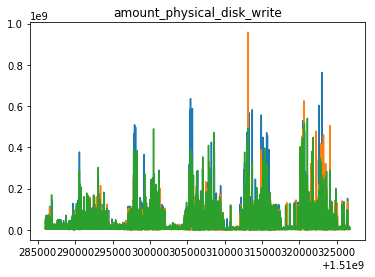

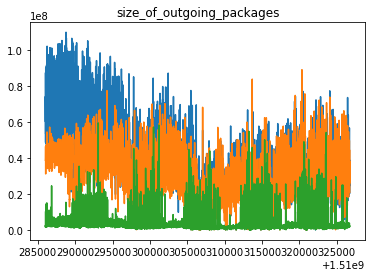

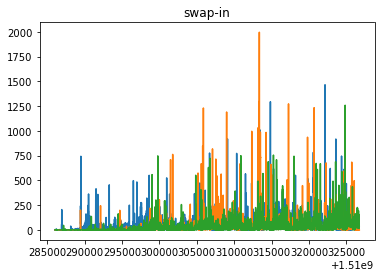

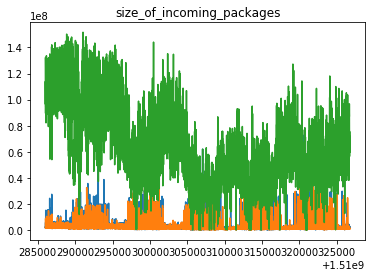

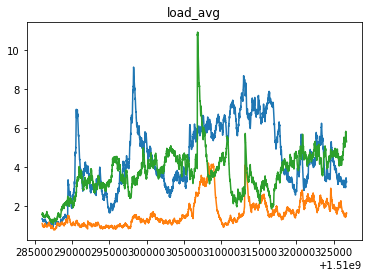

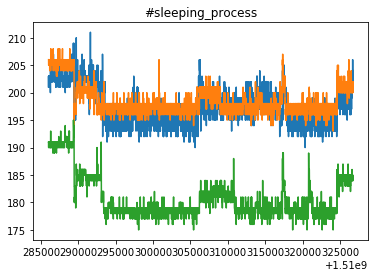

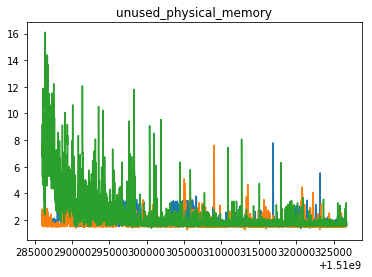

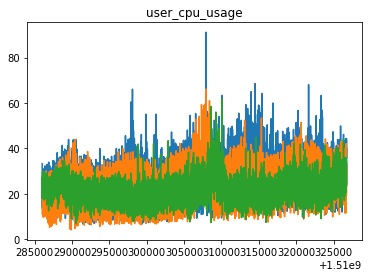

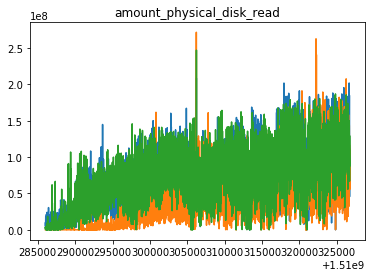

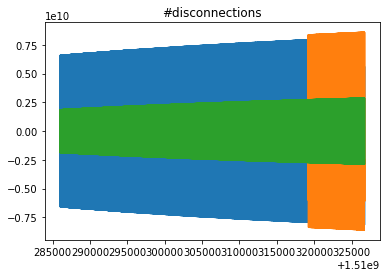

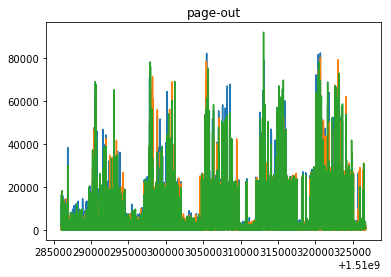

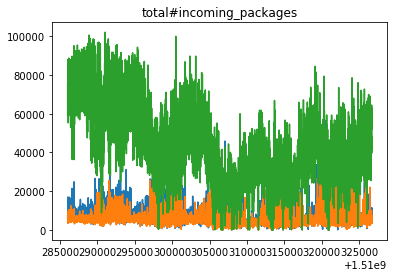

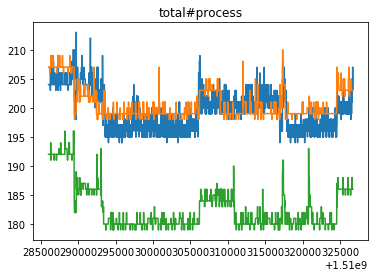

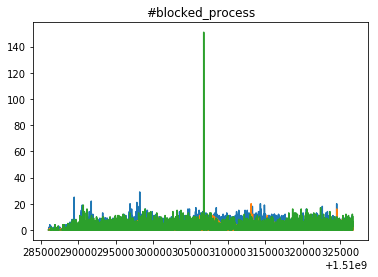

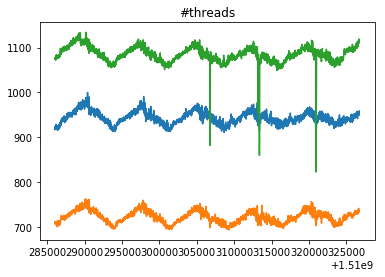

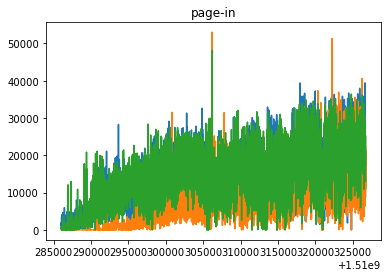

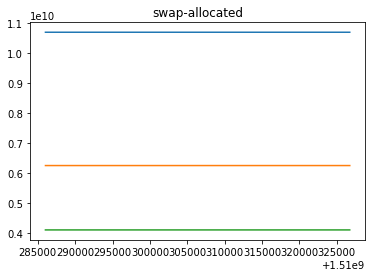

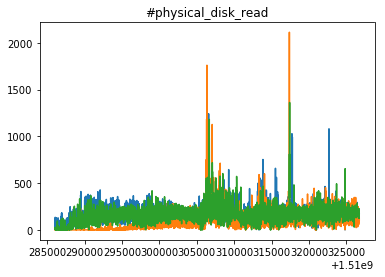

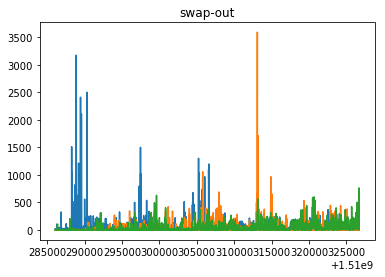

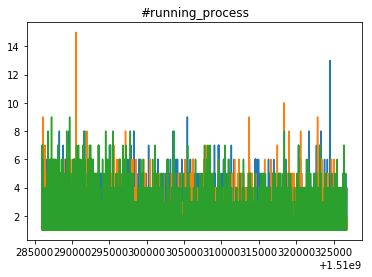

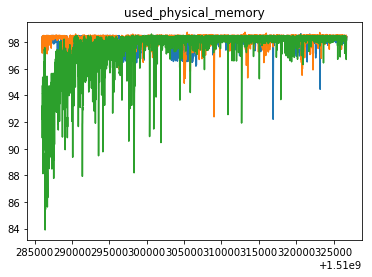

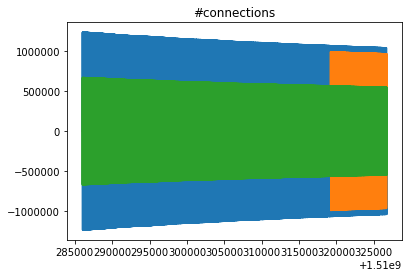

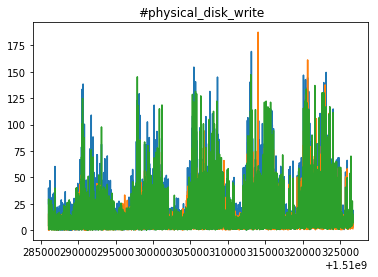

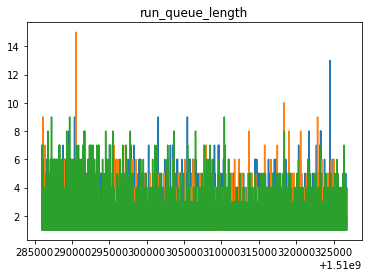

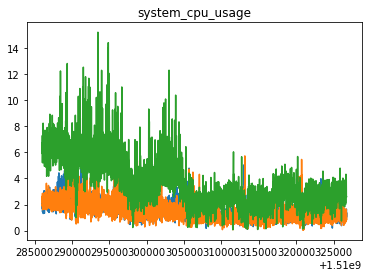

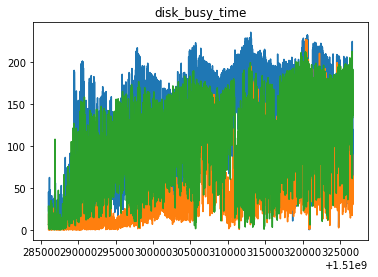

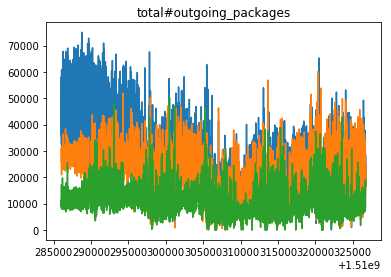

In [6]:
def draw_plot_for_metric(m1, m2, m3):
    for metric in m1.record_map.keys():
        plt.figure()
        plt.title(metric)
        plt.plot(map(lambda r: r.timestamp, m1.record_map[metric]),
                 map(lambda r: r.value, m1.record_map[metric]))
        plt.plot(map(lambda r: r.timestamp, m2.record_map[metric]),
                 map(lambda r: r.value, m2.record_map[metric]))
        plt.plot(map(lambda r: r.timestamp, m3.record_map[metric]),
                 map(lambda r: r.value, m3.record_map[metric]))
        plt.show()

draw_plot_for_metric(m1, m2, m3)

# for r in m2.log_records:
#     if r.type == '#disconnections':
#         print r.type, r.value

### Summarize Records by Interval

In [7]:
# print sorted(m1.record_map.keys())
METRICS_ORDER = ['#blocked_process', '#connections', '#disconnections', '#physical_disk_read',
                     '#physical_disk_write', '#running_process', '#sleeping_process', '#threads',
                     'amount_physical_disk_read', 'amount_physical_disk_write', 'disk_busy_time',
                     'load_avg', 'page-in', 'page-out', 'run_queue_length', 'size_of_incoming_packages',
                     'size_of_outgoing_packages', 'swap-allocated', 'swap-in', 'swap-out', 'system_cpu_usage',
                     'total#incoming_packages', 'total#outgoing_packages', 'total#process', 'unused_physical_memory',
                     'used_physical_memory', 'user_cpu_usage']
len(METRICS_ORDER)

27

In [8]:
len(m1.log_records), len(m2.log_records), len(m3.log_records)

(228832, 171049, 174204)

In [9]:
interval = 30
fv_m1 = IntervaledSingleMachineFeatureVectors(m1.log_records, start_time, end_time, interval)
fv_m2 = IntervaledSingleMachineFeatureVectors(m2.log_records, start_time, end_time, interval)
fv_m3 = IntervaledSingleMachineFeatureVectors(m3.log_records, start_time, end_time, interval)

assert len(fv_m1) == len(fv_m2) and len(fv_m1) == len(fv_m3)
print len(fv_m1.fvs), \
    (end_time - start_time) / 30, \
    len(fv_m1.intervals)



1357 1357 1357


In [10]:
len(fv_m1.fvs[5])

81

### Draw intervaled throughputs (avg. value)

### Horizontal Concatenation

In [11]:
fv_mtx = np.concatenate(
    (np.array(fv_m1.fvs), 
     np.array(fv_m2.fvs), 
     np.array(fv_m3.fvs)
    ),
    axis=1
)
fv_mtx.shape  # 3 * 81 + 3

(1357, 243)

### Write into file (in the log folder)

In [12]:
folder_name = log_folder.split(os.sep)[-1]
data_file_path = log_folder + os.sep + folder_name + ".numpy"
print data_file_path

/Users/luoshangpan/Documents/pci_experiment_data/01_normal_Nov10/01_normal_Nov10.numpy


In [13]:
with open(data_file_path, "w") as fh:
    np.save(fh, fv_mtx)


### Lalbel the above matrix
#### Define Performance Crisis
An interval is labeled as a performance crisis if any of these condition is satisfied:
1. avg throughput during this interval < 90 (around 50% of the avg. normal throughput)
2. min throughput during this interval < 50

#### Performance Crisis Types:
| Type | Label | Remark |
| --- | --- | --- |
| **Normal** | 0 | |
| **Not Enough Memory**  | 1 | Forced to use Swap or decrease cache size |
| **Unstable Network** | 2 | temporary failure in network interface |
| **Network Congestion** | 3 | Too much traffice on a certain machine |


In [14]:
with open(data_file_path, "r") as fh:
    fv_mtx = np.load(fh)

In [15]:
# Clean up the matrix 
# when in some interval, there is no record for a feature, -100.0 will be assigned

# for i in xrange(fv_mtx.shape[0]):
#     print fv_mtx[i, -1]
print fv_mtx.shape
# print np.abs(np.min(fv_mtx, axis=1) + 100) < 0.001   # filtering those intervals which have - 100.0 in them (our special value during preprocessing)
print np.any(np.abs(fv_mtx + 100) < 0.001, axis=1) == False   # filtering those intervals which have - 100.0 in them (our special value during preprocessing)
fv_mtx = fv_mtx[ np.any(np.abs(fv_mtx + 100) < 0.001, axis=1) == False, :]
fv_mtx.shape

(1357, 243)
[ True  True  True ...,  True  True  True]


(1357, 243)

In [19]:
"""
Label each fv with the defined condition
"""

fv_label_mtx = np.zeros(shape=(fv_mtx.shape[0], fv_mtx.shape[1] + 1))
print "FV Data Matrix Dimension: ", fv_mtx.shape 
print "Final Data Matrix Dimension: ", fv_label_mtx.shape 
# Copy Feature
fv_label_mtx[:, :fv_mtx.shape[1]] = fv_mtx[:, :fv_mtx.shape[1]]
for i in xrange(fv_mtx.shape[1]):
    assert np.all(fv_label_mtx[:, i] == fv_mtx[:, i])
assert fv_label_mtx.shape[0] == fv_mtx.shape[0]
# Set Label
for i in xrange(fv_label_mtx.shape[0]):
#     print int(fv_mtx[i, -3]), int(fv_mtx[i, -2]), int(fv_mtx[i, -1]) # Max, Avg, Min
    fv_label_mtx[i, -1] = CUR_ERROR_TYPE
fv_label_mtx[:, -1]

FV Data Matrix Dimension:  (1357, 243)
Final Data Matrix Dimension:  (1357, 244)


array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

Labeled Data File Path:  /Users/luoshangpan/Documents/pci_experiment_data/01_normal_Nov10/01_normal_Nov10_labeled.numpy


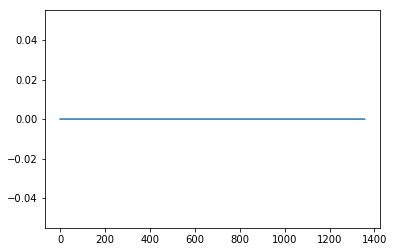

(1357, 244)


In [20]:
# Plot and Save data 
def plot_labels(fv_label_mtx):
    plt.figure()
    labels = fv_label_mtx[:, -1]
    plt.plot(labels)
    plt.show()

labeled_data_file_path = log_folder + os.sep + folder_name + "_labeled.numpy"
print "Labeled Data File Path: ", labeled_data_file_path
with open(labeled_data_file_path, "w") as fh:
    plot_labels(fv_label_mtx)
    print fv_label_mtx.shape
    np.save(fh, fv_label_mtx)

(1357, 244)


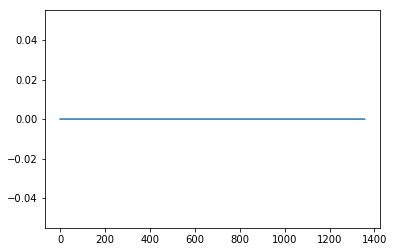

In [21]:
with open(labeled_data_file_path, "r") as fh:
    fv_label_mtx1 = np.load(fh)
    print fv_label_mtx1.shape
    plot_labels(fv_label_mtx1)